In [2]:
import pandas as pd
import numpy as np
import string
import openpyxl
import random
import matplotlib.pyplot as plt

## 상관관계 파일 만들기

In [3]:
data = pd.read_excel("202204_출고_주문번호추가.xlsx", skiprows=[0]) # <---- 각자 적재데이터파일 오픈하면 됩니다. 
data.head()

,No,플랜트,플랜트명,차수,주문일자,매장코드,매장,상품코드,상품명,운송장번호,...,검수수량,출력일시,출력자,몰구분,DAS여부,DAS차수,DAS지시번호,BOXNO,CELLNO,추가박스여부
0,1.0,192,프리덤(0192),1.0,2022/04/21,0192-1,프리덤 택배출고,802980111116,히말라야 핑크솔트,5.620936e+11,...,1,NaN,NaN,NaN,N,0.0,NaN,NaN,NaN,N
1,2.0,120,제로투원(0120),1.0,2022/04/01,0120-1,제로투원 택배출고,6261108117326,샤프란 향신료 20g,5.620932e+11,...,1,NaN,NaN,NaN,N,0.0,NaN,NaN,NaN,N
2,3.0,176,창고이전-더식스코리아(0176),1.0,2022/04/01,0176-01,더식스코리아-택배,5285001951833,Elegance Plus Shaving Gel 500ml,5.620932e+11,...,1,NaN,NaN,NaN,N,0.0,NaN,NaN,NaN,N
3,4.0,106,올댓글로벌(0106),1.0,2022/04/06,0106-1,올댓글로벌 택배,8000070021341,원두커피: 3. 라바짜 그란에스프레소,5.620933e+11,...,6,NaN,NaN,NaN,N,0.0,NaN,NaN,NaN,N
4,5.0,203,(주)디앤씨웹툰비즈(0203),1.0,2022/04/06,0203,디앤씨웹툰비즈-택배,VD-MT-002,악역의 엔딩은 죽음뿐 마스킹 테이프 vol.2,5.620933e+11,...,4,NaN,NaN,NaN,N,0.0,NaN,NaN,NaN,N


+ 상품명에 이상치 제거 필요

In [4]:
data['상품명'] = data['상품명'].replace('\n','',regex=True)
data['상품코드'] = data['상품코드'].replace('\n','',regex=True)

## 상관관계 making 함수 .ver1

In [5]:
def make_relation():
    one_to_one = []
    relation_list =[('플랜트','플랜트명'),('매장코드','매장'),('상품코드','상품명')]
    
    for key,value in relation_list:
        relation = []
        for i in range(len(data[key])):
            if (data[key][i],data[value][i]) not in relation:
                relation.append((data[key][i],data[value][i]))
        one_to_one.append(relation)       
    return one_to_one

## 상관관계 making 함수 .ver2

***플랜트 --->플랜트명, 매장코드, 매장 4개의 columns가 다 상관관계를 가진다.***

**.ver1의 문제점 : 플랜트 ---> 플랜트명, 매장코드---> 매장 으로 진행하면 어색한 상황이 생김.**
>ex) 플랜트: '001', 플랜트명: '롯데(001)' but 매장코드: '002-1', 매장: '신세계 택배'

In [6]:
dependent_list = [['플랜트','플랜트명','매장코드','매장'],['상품코드','상품명']]
#Input : 상관관계 2차원 list
#Output : 상관관계 txt파일 생성
def make_relation(relation_list):
    result = []
    for relation in relation_list:
        relation_value = []
        for i in range(len(data[relation[0]])):
            one_to_one = []
            for col in relation:
                one_to_one.append(data[col][i])
            if one_to_one not in relation_value:
                relation_value.append(one_to_one)
        result.append(relation_value)
    
    result = np.array(result)
    for i in range(len(result)):
        np.savetxt('relation '+ str(i+1) + '.txt',result[i], fmt='%s',delimiter='|')
        print(f'파일생성----> relation {i+1}.txt 파일이 생성되었습니다.')
        
#실행
make_relation(dependent_list)

파일생성----> relation 1.txt 파일이 생성되었습니다.
파일생성----> relation 2.txt 파일이 생성되었습니다.


C:\Users\oryuk\AppData\Local\Temp\ipykernel_11024\2498707524.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array(result)


## `상관관계 함수 .ver2`를 이용하여 `주문 내역 생성 함수` 수정하기.

> `주의사항` 구현의 편의를 위하여, 적재데이터의 columns의 순서가 바뀌었음. (dependent한 특성들 + independent한 특성)
>> 아래코드 참고!!

In [7]:
columns=['플랜트', '플랜트명', '매장코드', '매장', '상품코드', '상품명', '차수', '주문일자','운송장번호',
       '운송장출력여부', '주문취소여부', '주문번호', '받는이', '우편번호', '주소1', '주소2', '전화번호1',
       '전화번호2', '배송기재사항', '판매가', '합포여부', '예정수량', '검수수량', '출력일시', '출력자', '몰구분',
       'DAS여부', 'DAS차수', 'DAS지시번호', 'BOXNO', 'CELLNO', '추가박스여부']

random_columns = ['차수','주문일자','운송장번호','운송장출력여부','주문취소여부','주문번호','받는이','우편번호','주소1','주소2','전화번호1','전화번호2',
                  '배송기재사항','판매가', '합포여부', '예정수량', '검수수량', '출력일시', '출력자', '몰구분','DAS여부', 'DAS차수', 'DAS지시번호', 'BOXNO', 'CELLNO', '추가박스여부']
dependent_columns = ['플랜트','상품코드']

## 포아송분포
+ 평균(lam)이 10인 포아송분포로부터 100개(size)의 난수를 생성.
+ 함수를 실행할 때마다 새로운 분포로 데이터를 만들 수 있음.
+ 가중치가 비슷한 경우가 많아지고 적거나 많은 경우는 적어짐(실제와 비슷?)

In [8]:
rand__pois = np.random.poisson(lam=10, size=100)
unique, counts = np.unique(rand__pois, return_counts=True)
rand__pois

array([10,  8, 11, 10, 17, 15,  6,  4, 10, 15,  9,  8, 12, 10,  5, 11, 16,
       10,  9, 13, 11, 12,  8, 12,  8,  7,  7, 13,  4, 12, 14, 11,  9, 11,
       18, 11, 13, 10,  2, 14, 14, 10, 15, 11, 14,  7,  9,  7, 12, 15, 12,
       11, 11, 10, 14,  9, 10, 12, 10, 10,  3,  9, 16, 11, 11,  6, 14,  9,
        9,  9, 11, 11,  9,  8,  9,  9, 13, 14, 10,  9,  5, 12, 12,  8, 16,
        6,  9,  7,  7,  9, 13, 12, 10,  9,  8,  5,  5, 14, 12, 12])

In [9]:
# 15개의 난수 분포
np.asarray((unique, counts)).T

array([[ 2,  1],
       [ 3,  1],
       [ 4,  2],
       [ 5,  4],
       [ 6,  3],
       [ 7,  6],
       [ 8,  7],
       [ 9, 16],
       [10, 13],
       [11, 13],
       [12, 12],
       [13,  5],
       [14,  8],
       [15,  4],
       [16,  3],
       [17,  1],
       [18,  1]], dtype=int64)

+ 평균이 20인 포아송분포로부터 생성된 난수를 각 특성의 sample들에 부여
> 서울특별시 : _, 경상북도 : _, 인천광역시 : _개, ...

<BarContainer object of 17 artists>

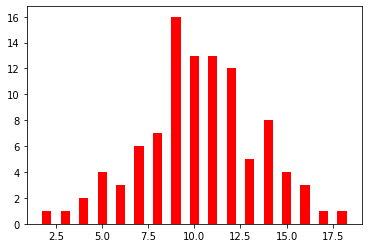

In [10]:
# 15개의 난수 분포그래프
plt.bar(unique, counts, width=0.5, color="red", align='center')

In [11]:
Dependent_set = {}
for i in range(len(dependent_list)):                       # 확장성 고려하여 다음과 같이 표현.
    f = np.loadtxt('relation '+ str(i+1) + '.txt', delimiter='|',dtype = 'str')
    Dependent_set[dependent_list[i][0]] = f
    
def one_column_random2(name):
    # 평균이 20인 포아송분포에서 각 col의 자료 개수만큼 가중치 생성
    rand_pois = np.random.poisson(lam=10, size=len(Dependent_set[name]))
    # 각 col의 가중치확인
    # print(rand_pois)
    return random.choices(Dependent_set[name], weights = rand_pois)[0]

# result=[]
# for i in one_column_random2('플랜트'):
#     result.append(i)

## 랜덤 데이터 생성 함수

In [12]:
# 랜덤 이름 생성 함수
def random_name() :
    first_name_samples = "김이박최정강조윤장임안변손권주심신"
    middle_name_samples = "민서예지도하주윤채현지형강호준수"
    last_name_samples = "준윤우원호후서연아은진엽수"
    
    result = ""
    result += random.choice(first_name_samples)
    result += random.choice(middle_name_samples)
    result += random.choice(last_name_samples)
    return result + '|'

In [13]:
# 랜덤 우편번호 생성 함수
def random_postcode() :
    number_samples = "0123456789"
    result = ""
    for _ in range(5):
        result += random.choice(number_samples)
    return result + '|'

In [14]:
# 랜덤 전화번호 생성 함수
def random_phone_number() :
    number_samples = "0123456789"
    result = "010-"
    for _ in range(4):
        result += random.choice(number_samples)
    result += '-'
    for _ in range(4):
        result += random.choice(number_samples)
    return result + '|'

+ 생성된 랜덤 데이터를 Sample/특성 파일에 저장

In [15]:
# 랜덤 이름 생성
f = open('Sample/받는이', 'w', encoding = 'utf-8')
for _ in range(30000) :
    f.write(random_name())
f.close()

# 랜덤 우편번호 생성
f = open('Sample/우편번호', 'w', encoding = 'utf-8')
for _ in range(30000) :
    f.write(random_postcode())
f.close()

# 랜덤 전화번호 생성
f = open('Sample/전화번호1', 'w', encoding = 'utf-8')
for _ in range(30000) :
    f.write(random_phone_number())
f.close()

f = open('Sample/전화번호2', 'w', encoding = 'utf-8')
for _ in range(30000) :
    f.write(random_phone_number())
f.close()

In [17]:
#샘플데이터 받아서 딕셔너리 자료형으로 변환 특성 종류 : 특성 value
Sample_set = {}

for col in columns :
    try :
        f = open('Sample/'+col,'r',encoding = 'utf-8')    #안호성이 만든 CODE/Sample/         각자의 저장 주소 참고하세요!
    except :
        f = open('Sample/'+col,'r',encoding = 'cp949')
    data = f.read()[:-1].split('|')
    Sample_set[col] = data

#input - 특성 종류
#output - 랜덤 특성 value
def one_column_random(name) :
    if name == '주문취소여부' or name == '추가박스여부' :
        return random.choices(['Y', 'N'], weights = (5, 95))[0]
    elif name == '운송장출력여부':
        return random.choices(['Y', 'N'], weights = (95, 5))[0]
    else:
        rand_pois = np.random.poisson(lam=10, size=len(Sample_set[name]))
        # 각 col의 가중치확인
        # print(rand_pois)
        return random.choices(Sample_set[name], weights = rand_pois)[0]

#input - 주문 수, "excel파일 이름"
#output - excel 파일 생성
def random_order_creater(n, name = 'Random_Sampe'):
    result = pd.DataFrame([],columns=columns)
    for _ in range(n):
        new_random_data = []
        for col in dependent_columns:
            for i in one_column_random2(col):
                new_random_data.append(i)
                
        for col in random_columns:
            new_random_data.append(one_column_random(col))
        result.loc[len(result)] = new_random_data
    result.to_excel(name+'.xlsx',encoding='utf-8')
    print('파일이 생성되었습니다.')

## 실행

In [18]:
random_order_creater(1000,'주문 내역 생성(특성 연결)')

ValueError: Total of weights must be greater than zero